**Full Name:** Athanasios Chouklis

**SRN:** 10396

**Email:** cathanasd@ece.auth.gr


Department of Electrical and Computer Engineering, Aristotle University of Thessaloniki

## **Second Assignment in Neural Networks - Deep Learning**

In the previous assignment, we employed both an **MLP** and **CNN** approach to the problem of image classification, working on the **CIFAR-10** database.

In this assignment we will examine how an **SVM** (Support Vector Machine) performs on the same database, but also a 'binary' version of it, which we will create simply by keeping only 2 classes from it and discarding the rest.

The principle behind this kind of classifier is mapping the data to a high-dimensional feature space so that data points can be categorized, even when the data are not otherwise linearly separable.

For the purposes of this assignment we will be using **Scikit-Learn**'s pre-made implementations of it since the runtime is low enough to be handled without GPU acceleration.

As always, we begin by importing the tools we'll be utilizing.

In [267]:
# PyTorch tools are imported for the purpose of comparison with an MLP

# Import PyTorch
import torch
from torch import nn

# Import PyTorch DataLoader and Learning Rate Scheduler
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import ExponentialLR

# Import torchvision data manipulation tools
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import PCA for PyTorch
from torch_pca import PCA as torchPCA

#Import the torchmetrics MulticlassAccuracy function
from torchmetrics.classification import MulticlassAccuracy


# Import scikit-learn tools

# Data loading and preprocessing tools
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from skimage.color import rgb2gray
from keras.datasets import cifar10

# Results visualization tools
from sklearn.metrics import ConfusionMatrixDisplay

# For Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

# The Classifiers themselves
from sklearn.neighbors import NearestCentroid, KNeighborsClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC


# Import numpy
import numpy as np

# Import matplotlib and pandas for data visualization
import matplotlib.pyplot as plt
import pandas as pd

# Import tqdm for progress bar
from tqdm.auto import tqdm

# Import timer to time our models
from timeit import default_timer as timer

# Import Dict and List for metrics plotting
from typing import Dict, List

# Import random for the creation of a random sample of images
import random

First we load the data for the SVM (Scikit-Learn) part and check to see the format in which we receive it.

In [234]:
(train_data, train_labels), (test_data, test_labels) = cifar10.load_data()

print('train_data shape:', train_data.shape)
print('train_labels shape:', train_labels.shape)
print('test_data shape:', test_data.shape)
print('test_labels shape:', test_labels.shape)

train_data shape: (50000, 32, 32, 3)
train_labels shape: (50000, 1)
test_data shape: (10000, 32, 32, 3)
test_labels shape: (10000, 1)


Then we do the same for the MLP (PyTorch) part, in the exact same way as we did in the first assignment.

In [235]:
# Setup device agnostic code; we want to use GPU acceleration if available
device = "cuda" if torch.cuda.is_available() else "cpu"

# Check to see if GPU acceleration is available
print(device)

# Set a random seed for reproducibility
torch.manual_seed(36)
torch.cuda.manual_seed(36)

# Setup training data
tensor_train_data = datasets.CIFAR10(
    root="data", # data download location
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, which we will turn into Torch tensors
    target_transform=None # option to transform labels as well
)

# Setup testing data
tensor_test_data = datasets.CIFAR10(
    root="data",
    train=False, # get test data
    download=True,
    transform=ToTensor()
)

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(tensor_train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # number of samples per batch
    shuffle=True # option to shuffle data every epoch
)

test_dataloader = DataLoader(tensor_test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

class_names = tensor_train_data.classes

cuda
Files already downloaded and verified
Files already downloaded and verified


### **Binary Classification**

First we'll test the performance of the SVM approach in the binary case. This will allow us to perform hyperparameter tuning without running into excessive runtime issues.

To that end, we turn the CIFAR-10 database into a binary one by removing all but the first two classes: airplane and automobile.

In [236]:
# Convert CIFAR-10 into a binary classification problem by isolating the airplane and automobile classes


# Airplane and automobile are the first two classes, so we want to find the indexes in the train/test label arrays for which the labels are <2

# Prepare a list for the indexes
train_indexes, test_indexes = [], []

# Iterate through the label arrays in search of the indexes
for i, label in enumerate(train_labels):
    if train_labels[i] < 2:
        train_indexes.append(i)

for i, label in enumerate(test_labels):
    if test_labels[i] < 2:
        test_indexes.append(i)

# We use those indexes on the original data to get a version of the dataset with only airplane and automobile images
b_train_data, b_train_labels = train_data[train_indexes], train_labels[train_indexes]
b_test_data, b_test_labels = test_data[test_indexes], test_labels[test_indexes]

# We reshape it so that each image is a single 3072-long vector, instead of a 3x32x32 tensor. This is how we will be using it for the most part.
b_train_data_reshaped = b_train_data.reshape(b_train_data.shape[0], -1)
b_test_data_reshaped = b_test_data.reshape(b_test_data.shape[0], -1)

# We check to see if the shape is as expected
print('b_train_data shape:', b_train_data_reshaped.shape)
print('b_train_labels shape:', b_train_labels.shape)
print('b_test_data shape:', b_test_data_reshaped.shape)
print('b_test_labels shape:', b_test_labels.shape)



b_train_data shape: (10000, 3072)
b_train_labels shape: (10000, 1)
b_test_data shape: (2000, 3072)
b_test_labels shape: (2000, 1)


Now that we've done that, let's run a preliminary test between the different Support Vector Classifiers that Scikit-Learn provides, and compare their performance.

In [237]:
# Prepare a dict for the results
model_results = {}

# Iterate over the classifiers
for model in [SVC, LinearSVC, NuSVC]:

    clf = model()   # Set the classifier 
    clf_name = clf.__class__.__name__ # Get the name of the classifier for the results dict

    start_time = timer()  # Start the timer
    clf.fit(b_train_data_reshaped, b_train_labels.ravel()) # Fit the classifier
    end_time = timer() # End the timer

    # Save the results, which we get by using the .score method of the classifier on both the training and testing data, to get the training and testing accuracy respectively
    model_results[clf_name] = {'Train accuracy': f"{clf.score(b_train_data_reshaped, b_train_labels.ravel())*100:.2f}%",
                               'Test accuracy': f"{clf.score(b_test_data_reshaped, b_test_labels.ravel())*100:.2f}%",
                               'Training time': f"{(end_time - start_time):.2f}s"}

# Save the results to a DataFrame
baseline_binary_results = pd.DataFrame(model_results)

# Show the DataFrame
baseline_binary_results

/home/redpanda/Documents/Auth/Neural_Networks/assignment/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,SVC,LinearSVC,NuSVC
Train accuracy,94.31%,95.24%,85.80%
Test accuracy,90.40%,72.50%,86.20%
Training time,31.66s,1599.33s,60.70s


We see that the regular `SVC` exhibits the best performance: shortest training time and best test accuracy.

`NuSVC` follows after it with **~5% less** accuracy for **double** the fit time, while `LinearSVC` fails catastrophically; not only does it perform **~15-20% worse** than the other two, it does so in a very runtime-costly way, taking **~27** minutes (**!**) to finish training - almost the entire runtime of the code cell (~30 minutes).

Since the standard `SVC` shows the most promise, we will choose that and go from there, using various methods to try and improve performance and/or runtime.

Last time we stuck to a strictly **model-driven** approach; this time we will also delve into some **data-driven** techniques, starting with **Grayscaling**.

In [238]:
# Use rgb2gray to convert the images to grayscale
gray_b_train_data = rgb2gray(b_train_data)
gray_b_test_data = rgb2gray(b_test_data)

# Reshape them, as we did before
gray_b_train_data_reshaped = gray_b_train_data.reshape(gray_b_train_data.shape[0], -1)
gray_b_test_data_reshaped = gray_b_test_data.reshape(gray_b_test_data.shape[0], -1)


# Below is the same exact testing method as before, only this time we use only one classifier instead of iterating through three of them

model_results = {}

clf = SVC()
clf_name = "Grayscale SVC"

start_time = timer()
clf.fit(gray_b_train_data_reshaped, b_train_labels.ravel())
end_time = timer()

model_results[clf_name] = {'Train accuracy': f"{clf.score(gray_b_train_data_reshaped, b_train_labels.ravel())*100:.2f}%",
                            'Test accuracy': f"{clf.score(gray_b_test_data_reshaped, b_test_labels.ravel())*100:.2f}%",
                            'Training time': f"{(end_time - start_time):.2f}s"}

# We use .iloc[:, [0]] to get only the first column of the previous DataFrame (the SVC part, which is the one we ultimately chose)
# and then we join it with the new results to directly compare current performance with baseline performance
grayscale_binary_results = pd.DataFrame(model_results)
grayscale_baseline_comparison = baseline_binary_results.iloc[:, [0]].join(grayscale_binary_results)
grayscale_baseline_comparison

,SVC,Grayscale SVC
Train accuracy,94.31%,92.74%
Test accuracy,90.40%,87.15%
Training time,31.66s,8.25s


As we suspected during the previous assignment when we had a look at the data, grayscaling was unlikely to be of help; it actually *hurts* performance.

Moving on to **Range Scaling**, something that was automatically applied by the PyTorch `ToTensor()` transform last time. We will test the Scikit-Learn `StandardScaler` and `MinMaxScaler`.

In [239]:
# Same testing method as before, only this time we iterate through scalers

model_results = {}
clf = SVC()

for scaler in [StandardScaler, MinMaxScaler]:

    scl = scaler()
    clf_name = f"{scl.__class__.__name__} SVC"

    # Do the scaling
    scaled_b_train_data = scl.fit_transform(b_train_data_reshaped)
    scaled_b_test_data = scl.transform(b_test_data_reshaped)

    start_time = timer()
    clf.fit(scaled_b_train_data, b_train_labels.ravel())
    end_time = timer()

    model_results[clf_name] = {'Train accuracy': f"{clf.score(scaled_b_train_data, b_train_labels.ravel())*100:.2f}%",
                               'Test accuracy': f"{clf.score(scaled_b_test_data, b_test_labels.ravel())*100:.2f}%",
                               'Training time': f"{(end_time - start_time):.2f}s"}

rangescale_binary_results = pd.DataFrame(model_results)
rangescale_baseline_comparison = baseline_binary_results.iloc[:, [0]].join(rangescale_binary_results)
rangescale_baseline_comparison

,SVC,StandardScaler SVC,MinMaxScaler SVC
Train accuracy,94.31%,94.69%,94.31%
Test accuracy,90.40%,90.40%,90.40%
Training time,31.66s,31.52s,30.98s


Range Scaling appears to have a negligibly negative impact. Testing accuracy remains the same but training accuracy either remains the same or becomes a bit larger (overfitting, since the testing accuracy did not increase).

Overall, not worth doing.

Now it's time to try out **PCA - Principal Component Analysis**. This is the most promising of the bunch, as it reduces the dimensionality of our data - making the training time faster - and also has the potential to simultaneously improve accuracy, as some of the information contained in the images may in fact be acting as 'noise'.

Of course there is a balance that needs to be kept, as reducing our data too much will lose too much information; we need to find the sweet spot of runtime and accuracy gain.

We will search for it in the **90-100%** explained variance range.

The test accuracy is maximized for threshold equal to 98.


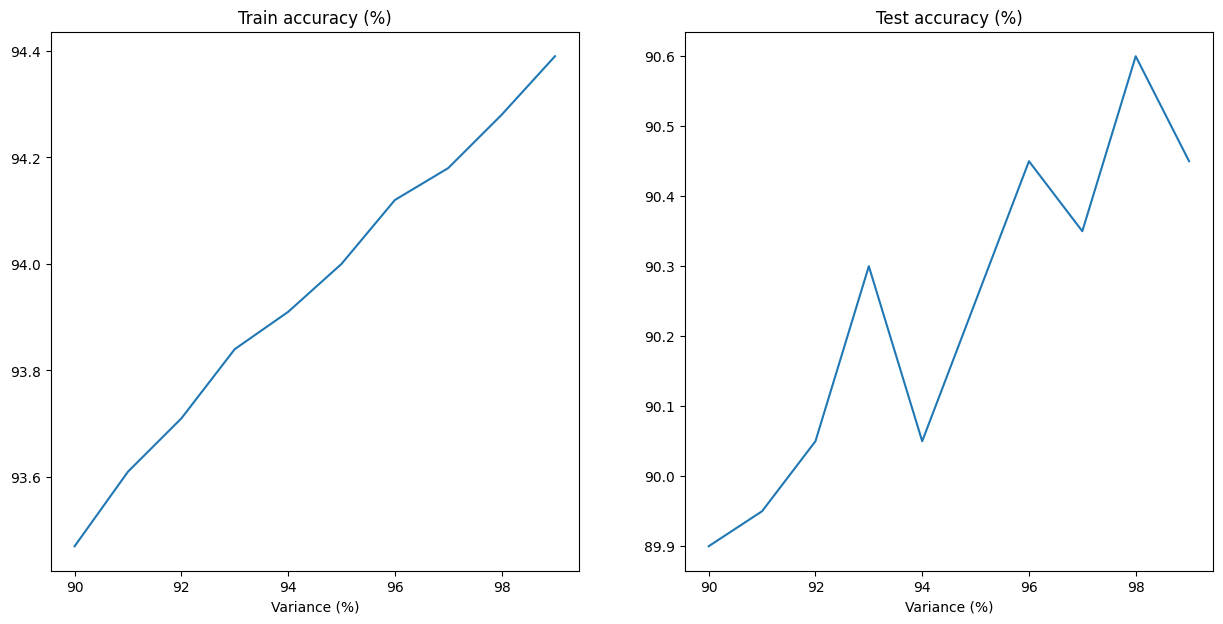

In [240]:
clf = SVC()

# Prepare lists for the train/test accuracy values; we'll get a set of 10 (one for each PCA variance threshold we'll try) and we want to plot them and find the max
train_accuracy_values = []
test_accuracy_values = []

# Iterate over the variance range
for p in range(90, 100):

    pca = PCA(p/100) # Set the PCA object with the variance threshold

    # Apply PCA to both the training and testing data
    pca_b_train_data = pca.fit_transform(b_train_data_reshaped)
    pca_b_test_data = pca.transform(b_test_data_reshaped)

    # Fit the model on the PCA-transformed data
    clf.fit(pca_b_train_data, b_train_labels.ravel())

    # Save the train and test accuracy values (getting them through the .score method) in the lists we prepared
    train_accuracy_values.append(clf.score(pca_b_train_data, b_train_labels.ravel())*100)
    test_accuracy_values.append(clf.score(pca_b_test_data, b_test_labels.ravel())*100)

p_range = list(range(90, 100))

# Setup a plot 
plt.figure(figsize=(15, 7))

# Plot train accuracy
plt.subplot(1, 2, 1)
plt.plot(p_range, train_accuracy_values)
plt.title('Train accuracy (%)')
plt.xlabel('Variance (%)')

# Plot test accuracy
plt.subplot(1, 2, 2)
plt.plot(p_range, test_accuracy_values)
plt.title('Test accuracy (%)')
plt.xlabel('Variance (%)')

# Find the index of the maximum test accuracy value, in order to find the corresponding best threshold
max_pca_test_accuracy_index = test_accuracy_values.index(max(test_accuracy_values))

best_threshold = p_range[max_pca_test_accuracy_index]

print(f"The test accuracy is maximized for threshold equal to {best_threshold}.")

It seems that the sweet spot is a threshold of **0.98**. Interestingly, the training accuracy steadily increases as the threshold increases, but the testing accuracy fluctuates wildly. This shows how finnicky it can be to find the correct amount of dimensionality reduction to apply to the data, such that the part that we actually care about (testing accuracy) is helped.

Now we should see how the SVC fares with a PCA transform using this 'ideal' value.

In [241]:
# Same method as the previous tests, the sole difference being that we apply PCA to the data and then feed that to the model, instead of using the data without modification

model_results = {}
clf = SVC()

pca = PCA(0.98)
clf_name = "PCA SVC"

# PCA application
pca_b_train_data = pca.fit_transform(b_train_data_reshaped)
pca_b_test_data = pca.transform(b_test_data_reshaped)

start_time = timer()
clf.fit(pca_b_train_data, b_train_labels.ravel())
end_time = timer()

model_results[clf_name] = {'Train accuracy': f"{clf.score(pca_b_train_data, b_train_labels.ravel())*100:.2f}%",
                            'Test accuracy': f"{clf.score(pca_b_test_data, b_test_labels.ravel())*100:.2f}%",
                            'Training time': f"{(end_time - start_time):.2f}s"}

pca_binary_results = pd.DataFrame(model_results)
pca_baseline_comparison = baseline_binary_results.iloc[:, [0]].join(pca_binary_results)
pca_baseline_comparison

,SVC,PCA SVC
Train accuracy,94.31%,94.28%
Test accuracy,90.40%,90.60%
Training time,31.66s,3.10s


The performance in terms of accuracy might as well be the same: we have a **0.2%** increase in test accuracy and a **0.03%** decrease in training accuracy. *Techincally* the model is more accurate while overfitting less, but the percentage increases are so small so as to be meaningless.

The *actual* benefit is in the performance increase in terms of **runtime**: from **~31** seconds down to **~3.1** (**!**) seconds - that is faster by around a factor of **10**.

This constitutes a massive reduction of computational expense and results in huge time savings; no reason not to use it.

Shifting now to a **model-driven** approach, we should test how the different kernels that are on offer stack up against each other.

We need to do this before looking into hyperparameter tuning, because although `GridSearchCV` can search for the best kernel as well, the standard SVC seems to run endlessly when used in conjunction with `kernel=linear`. This means we need to implement it differently.

In [242]:
# Same testing method, just iterating though kernels this time

model_results = {}

for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
    if kernel == 'linear':
        clf = LinearSVC() # Regular SVC with kernel set to linear seems to never finish, so the linear option has to be tested this way
    else:
        clf = SVC(kernel=kernel)
    
    clf_name = kernel.capitalize()

    start_time = timer()
    clf.fit(pca_b_train_data, b_train_labels.ravel())
    end_time = timer()
    
    model_results[clf_name] = {'Train accuracy': f"{clf.score(pca_b_train_data, b_train_labels.ravel())*100:.2f}%",
                               'Test accuracy': f"{clf.score(pca_b_test_data, b_test_labels.ravel())*100:.2f}%",
                               'Training time': f"{(end_time - start_time):.2f}s"}
    
kernel_comparison = pd.DataFrame(model_results)
kernel_comparison

,Linear,Poly,Rbf,Sigmoid
Train accuracy,83.49%,93.44%,94.28%,67.85%
Test accuracy,82.75%,85.40%,90.60%,69.10%
Training time,3.78s,3.96s,3.06s,2.87s


We see that the `RBF` kernel (the one used by default) outperforms the rest, with `poly` coming in at a close second with **~5% less** test accuracy.

`LinearSVC` seems to do a lot better with PCA applied, enjoying a **10%** test accuracy increase compared to last time and finishing in only 3 seconds. `Sigmoid` underperforms noticeably.

We can now begin the process of **hyperparameter tuning**.

In [243]:
# We use the SVC estimator  which was found to be the best
# We don't search through kernels - we already did that; we use RBF (no need to set it explicitly, as RBF is the default one for SVC) which we found to be the best

# The data we feed to it is PCA-transformed with a 98% variance threshold, as was found to be the best

# We ignore the 'degree' parameter because it only applies to the polynomial kernel, which we are not using
# Similarly, we ignore the 'coef0' parameter because it is only significant for the poly and sigmoid kernels

# We don't mess with the 'cv' parameter because we want to use the default number of folds for cross-validation, which is 5
# We set n_jobs to -1 to use all available CPU cores for the computation in order to minimize the time it takes to run the search


param_tuning = GridSearchCV(estimator=SVC(),
                            param_grid={'C': [0.1, 1, 10, 100, 500, 1000], # This search for the best C is rather 'rough'; we will refine it later
                                        'gamma': ['scale', 'auto'],
                                        'shrinking': [True, False],
                                        'class_weight': [None, 'balanced']},
                            n_jobs = -1)

start_time = timer()
param_tuning.fit(pca_b_train_data, b_train_labels.ravel())
end_time = timer()

print(f"Best parameters: {param_tuning.best_params_}")
print(f"Time taken: {end_time - start_time} seconds")

Best parameters: {'C': 10, 'class_weight': None, 'gamma': 'scale', 'shrinking': True}
Time taken: 1134.900869828998 seconds


Funnily enough, all the best parameters are the default ones, except for the `C` parameter, which controls the regularization strength - how much the classifier is penalized for guessing wrong.

We deliberately conducted only a coarse search on it, as we needed to first narrow it down a bit before exploring it more thoroughly (wading through the values *1-1000* one by one would take far too long).

Since `GridSearchCV` landed on **10** from a value list of [ 0.1, 1, 10, 100, 500, 1000 ], we can assume that the best `C` will be found somewhere in the order of magnitude of **1-10** or **10-100**.

We will search through these two ranges with a step of **1** and **10** respectively, to get through both of them in an equal number of steps (10) and thus search them equally thoroughly.

The test accuracy is maximized for C=3.


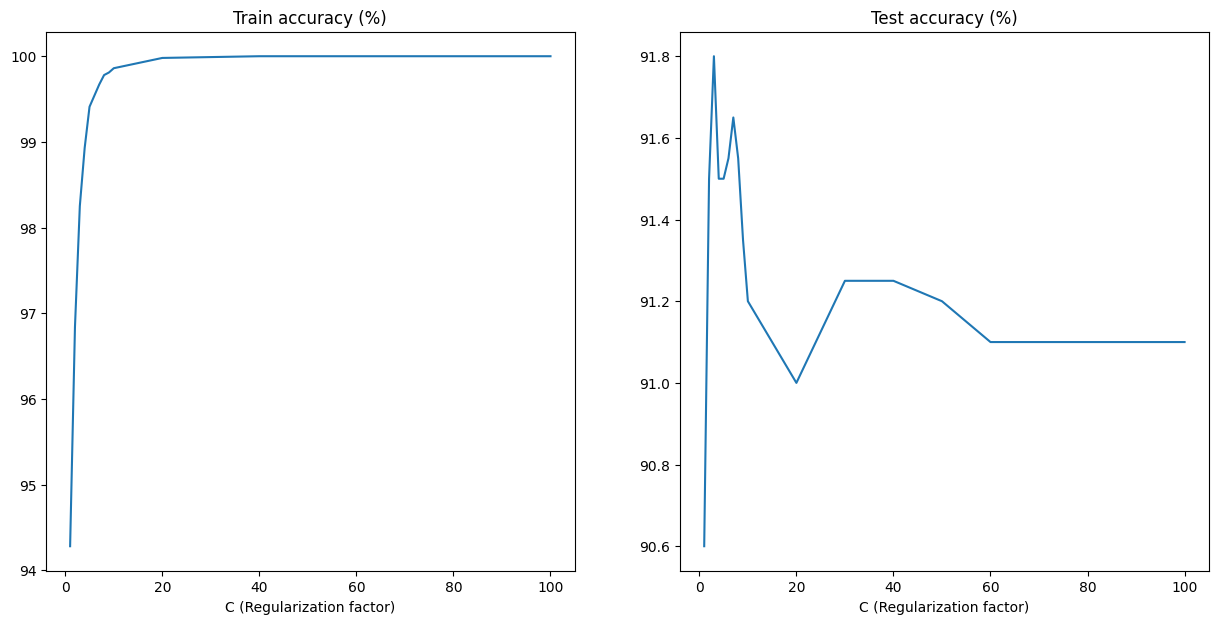

In [244]:
# Similarly to our PCA experiment, we will plot the train and test accuracy values for different values of the regularization factor C to find the best C

# So, we prepare lists, as we did before
train_accuracy_values = []
test_accuracy_values = []

# We iterate through the range 1-10 in steps of 1
for C in range(1, 10):
    clf = SVC(C=C)
    clf.fit(pca_b_train_data, b_train_labels.ravel())
    train_accuracy_values.append(clf.score(pca_b_train_data, b_train_labels.ravel())*100)
    test_accuracy_values.append(clf.score(pca_b_test_data, b_test_labels.ravel())*100)

# We then iterate through the range 10-100 in steps of 10
for C in range (10, 110, 10):
    clf = SVC(C=C)
    clf.fit(pca_b_train_data, b_train_labels.ravel())
    train_accuracy_values.append(clf.score(pca_b_train_data, b_train_labels.ravel())*100)
    test_accuracy_values.append(clf.score(pca_b_test_data, b_test_labels.ravel())*100)

# We combine the two ranges into a single list of values for the x-axis
C_range = list(range(1, 10)) + list(range(10, 110, 10))

# Setup a plot 
plt.figure(figsize=(15, 7))

# Plot train accuracy
plt.subplot(1, 2, 1)
plt.plot(C_range, train_accuracy_values)
plt.title('Train accuracy (%)')
plt.xlabel('C (Regularization factor)')

# Plot test accuracy
plt.subplot(1, 2, 2)
plt.plot(C_range, test_accuracy_values)
plt.title('Test accuracy (%)')
plt.xlabel('C (Regularization factor)')

# Find the index of the maximum test accuracy value in order to find the best C
max_test_accuracy_index = test_accuracy_values.index(max(test_accuracy_values))

best_C = C_range[max_test_accuracy_index]

print(f"The test accuracy is maximized for C={best_C}.")

Now that we have found that the best value for `C` is **3**, we can conduct a final test to see how the best version of our classifier performs in the binary case.

In [245]:
# Same protocol

model_results = {}
best_clf = SVC(C=best_C) 
clf_name = "Tuned PCA SVC"

start_time = timer()
best_clf.fit(pca_b_train_data, b_train_labels.ravel())
end_time = timer()

model_results[clf_name] = {'Train accuracy': f"{best_clf.score(pca_b_train_data, b_train_labels.ravel())*100:.2f}%",
                            'Test accuracy': f"{best_clf.score(pca_b_test_data, b_test_labels.ravel())*100:.2f}%",
                            'Training time': f"{(end_time - start_time):.2f}s"}

tuned_pca_binary_results = pd.DataFrame(model_results)
tuned_pca_binary_comparison = pca_baseline_comparison.join(tuned_pca_binary_results)
tuned_pca_binary_comparison

,SVC,PCA SVC,Tuned PCA SVC
Train accuracy,94.31%,94.28%,98.25%
Test accuracy,90.40%,90.60%,91.80%
Training time,31.66s,3.10s,3.19s


We see worse overfitting but in exchange we get a **1.20%** increase in test accuracy.

All in all, we were not really able to squeeze that much more accuracy out of the classifier, and the most significant improvement came from applying PCA to the data, which drastically reduced computational expense while very slighly increasing accuracy.

### **Multiclass Classification**

In this section, aside from seeing how well our SVM holds up to a multiclass problem, we will also compare its performance with that of an MLP which has only **one** hidden layer and uses Hinge loss for optimization. Additionally, we will look at some examples of correct and incorrect classification.

First things first, we test the SVM, applying only the techniques that proved beneficial (keeping in mind that internally, Scikit-Learn always uses a *One-VS-One* scheme to train models).

In [246]:
# We now reshape the full CIFAR-10 dataset into a usable format (each sample a 3072-long vector)
train_data_reshaped = train_data.reshape(train_data.shape[0], -1)
test_data_reshaped = test_data.reshape(test_data.shape[0], -1)

# We apply PCA
pca_train_data = pca.fit_transform(train_data_reshaped)
pca_test_data = pca.transform(test_data_reshaped)

# We test the model exactly as before, this time with the full dataset
model_results = {}
best_clf_mul = SVC(C=best_C)

clf_name = "Multiclass Tuned PCA SVC"

start_time = timer()
best_clf_mul.fit(pca_train_data, train_labels.ravel())
end_time = timer()

model_results[clf_name] = {'Train accuracy': f"{best_clf_mul.score(pca_train_data, train_labels.ravel())*100:.2f}%",
                            'Test accuracy': f"{best_clf_mul.score(pca_test_data, test_labels.ravel())*100:.2f}%",
                            'Training time': f"{(end_time - start_time):.2f}s"}

tuned_pca_results = pd.DataFrame(model_results)
tuned_pca_results

,Multiclass Tuned PCA SVC
Train accuracy,86.31%
Test accuracy,56.71%
Training time,206.95s


Our SVM actually performs **~10% better** than our MLP did last time, although the CNN still beats it by **~10%**. Runtime is vastly increased compared to the binary case, as expected.

Time to take a look at some examples of correct and incorrect classification.

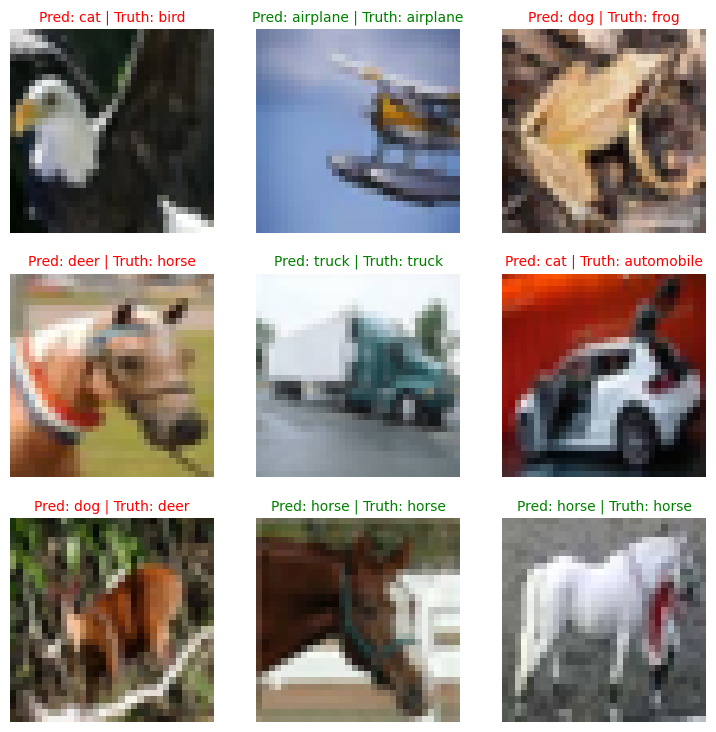

In [247]:
# Needed to store the samples
example_samples = []
example_labels = []

# Set random seed for reproducibility
random.seed(36)

# Get 9 random samples from the test data
for sample in random.sample(list(zip(test_data, test_labels)), k=9):
    example_samples.append(sample[0])
    example_labels.append(sample[1][0])

# Reshape the samples such that PCA can be applied to them, apply PCA, and predict the classes
pred_classes = best_clf_mul.predict(pca.transform([sample.reshape(-1) for sample in example_samples]))

# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(example_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample)

  # Find the prediction label (in text form)
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form)
  truth_label = class_names[example_labels[i]] 

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  
  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

The examples of false classification are not easy to explain from a human standpoint.

The distinctive silhouette of an eagle's head along with its beak really shouldn't fall through the cracks and be categorized as a cat, even if there are a lot of cats with black-and-white coloration in the database.

In the same vein:

- a frog is misidentified as a dog despite the former's characteristic hind legs,

- a close-up of a horse is misidentifed as a deer despite the presence of a lead (and/or the lack of antlers),

- an automobile is misidentified as a cat (!) despite the clear presence of wheels, a car body shape and backlights,

- a deer is misidentified as a dog despite being a much larger animal.

The behaviour of the classifier seems very unpredictable; perhaps it is learning to distinguish based on the background and other 'peripherals', but even then these mistakes are not straightforwardly explicable.

Perhaps a **Confusion Matrix** can give us some further insight. Plotting one with the help of Scikit-Learn can be done very simply:

Text(0.5, 1.0, 'Confusion Matrix')

<Figure size 900x900 with 0 Axes>

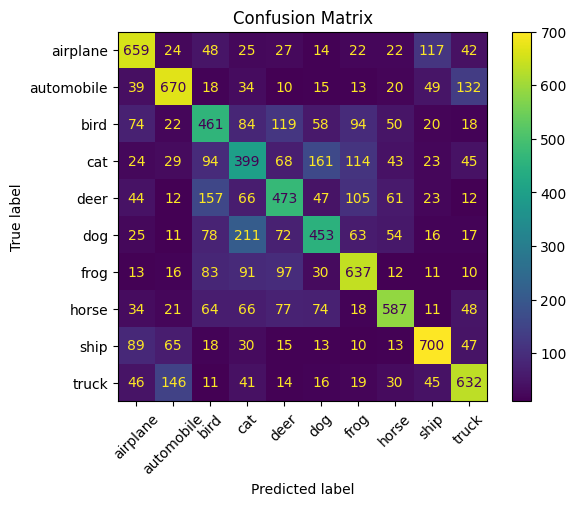

In [266]:
plt.figure(figsize=(9, 9))
ConfusionMatrixDisplay.from_predictions(test_labels.ravel(), best_clf_mul.predict(pca_test_data), display_labels=class_names, xticks_rotation=45)
plt.title('Confusion Matrix')

As we expected, the model performs very well with airplanes and automobiles, since we are using hyperparameters that were found to be best when assessing classification performance between these 2 classes.

However it also appears to do well with ships, and to an extent, frogs and trucks. Performance is notably lacking when it comes to the rest of the animals, which explains *some* of what we've seen.

Finally, in the interest of comparing the SVM's performance to that of an MLP (1 hidden layer only, using Hinge loss), we will use the functions we created in the previous assignment utilizing PyTorch. This will allow us to leverage ROCm for GPU acceleration.

**Training function**

In [248]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               scheduler: torch.optim.lr_scheduler._LRScheduler,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_pred, y)

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward (backpropagation)
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    if scheduler is not None:
        scheduler.step()

    # Calculate loss and accuracy per epoch
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    # Return metrics
    return train_loss, train_acc

**Testing function**

In [249]:
def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(test_pred,y)
        
        # Calculate loss and accuracy per epoch
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)

        # Return metrics
        return test_loss, test_acc

**Metrics plotting function**

In [250]:
def plot_metrics_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss_values = results['train_loss']
    test_loss_values = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    acc_values = results['train_acc']
    test_acc_values = results['test_acc']

    # Figure out how many epochs there were
    num_of_epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(num_of_epochs, loss_values, label='train_loss')
    plt.plot(num_of_epochs, test_loss_values, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(num_of_epochs, acc_values, label='train_accuracy')
    plt.plot(num_of_epochs, test_acc_values, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

Combination of the above three, to avoid rewriting code:

In [251]:
def test_train_plot(model: torch.nn.Module,
               data_loader_train: torch.utils.data.DataLoader,
               data_loader_test: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               epochs,
               scheduler: torch.optim.lr_scheduler._LRScheduler):

    # Create a results dictionary to store the metrics
    results = {"train_loss": [],
            "train_acc": [],
            "test_loss": [],
            "test_acc": []
        }

    # Start the timer
    start_time = timer()

    # Training loop
    for epoch in tqdm(range(epochs)):
        # Training step
        train_loss, train_acc = train_step(data_loader=data_loader_train, 
            model=model, 
            loss_fn=loss_fn,
            optimizer=optimizer,
            accuracy_fn=accuracy_fn,
            scheduler=scheduler
        )
        
        #Testing step
        test_loss, test_acc = test_step(data_loader=data_loader_test,
            model=model,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
        )
        
        # Print out the loss and accuracy
        if epochs == 51:
            if epoch % 10 == 0:
                print(f"Epoch: {epoch}\n---------")
                print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc*100:.2f}%")
                print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc*100:.2f}%\n")
        if epochs == 101:
            if epoch % 20 == 0:
                print(f"Epoch: {epoch}\n---------")
                print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc*100:.2f}%")
                print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc*100:.2f}%\n")
        
        # Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage and plotting
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # End the timer and print out how long it took
    end_time = timer()
    print(f"Total training time: {end_time-start_time:.3f} seconds")

    plot_metrics_curves(results)

Creating the MLP is done in the same manner as the first assignment, using a PyTorch `class`.

In [263]:
class SimpleMLP(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # turn the input into a 2D tensor of dimension (batch_size, input_shape)
            nn.Linear(in_features=input_shape, out_features=hidden_units), # in_features = number of features in a data sample (in this case, 3072 pixels)
            nn.ReLU(), # activation function
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.layer_stack(x)

This is where we set things like which optimizer we'll use, how many epochs we'll run the model through, whether we'll use a scheduler (and which one, etc.).

In general we make the same choices we made in the first assignment, only this time we will use `MultiMarginLoss` as our loss function: Hinge Loss can be extended for use in multiclass problems, and `MultiMarginLoss` is a ready-made PyTorch implementation of that.

  1%|          | 1/101 [00:08<13:33,  8.13s/it]

Epoch: 0
---------
Train loss: 0.63794 | Train accuracy: 24.87%
Test loss: 0.60137 | Test accuracy: 26.05%



 21%|██        | 21/101 [02:50<10:48,  8.10s/it]

Epoch: 20
---------
Train loss: 0.42472 | Train accuracy: 37.89%
Test loss: 0.44151 | Test accuracy: 36.95%



 41%|████      | 41/101 [05:33<08:08,  8.15s/it]

Epoch: 40
---------
Train loss: 0.40853 | Train accuracy: 39.45%
Test loss: 0.42689 | Test accuracy: 38.34%



 60%|██████    | 61/101 [08:15<05:22,  8.07s/it]

Epoch: 60
---------
Train loss: 0.40670 | Train accuracy: 39.61%
Test loss: 0.42624 | Test accuracy: 38.19%



 80%|████████  | 81/101 [10:57<02:41,  8.08s/it]

Epoch: 80
---------
Train loss: 0.40646 | Train accuracy: 39.67%
Test loss: 0.42611 | Test accuracy: 38.20%



100%|██████████| 101/101 [13:40<00:00,  8.12s/it]

Epoch: 100
---------
Train loss: 0.40645 | Train accuracy: 39.65%
Test loss: 0.42610 | Test accuracy: 38.20%

Total training time: 820.607 seconds


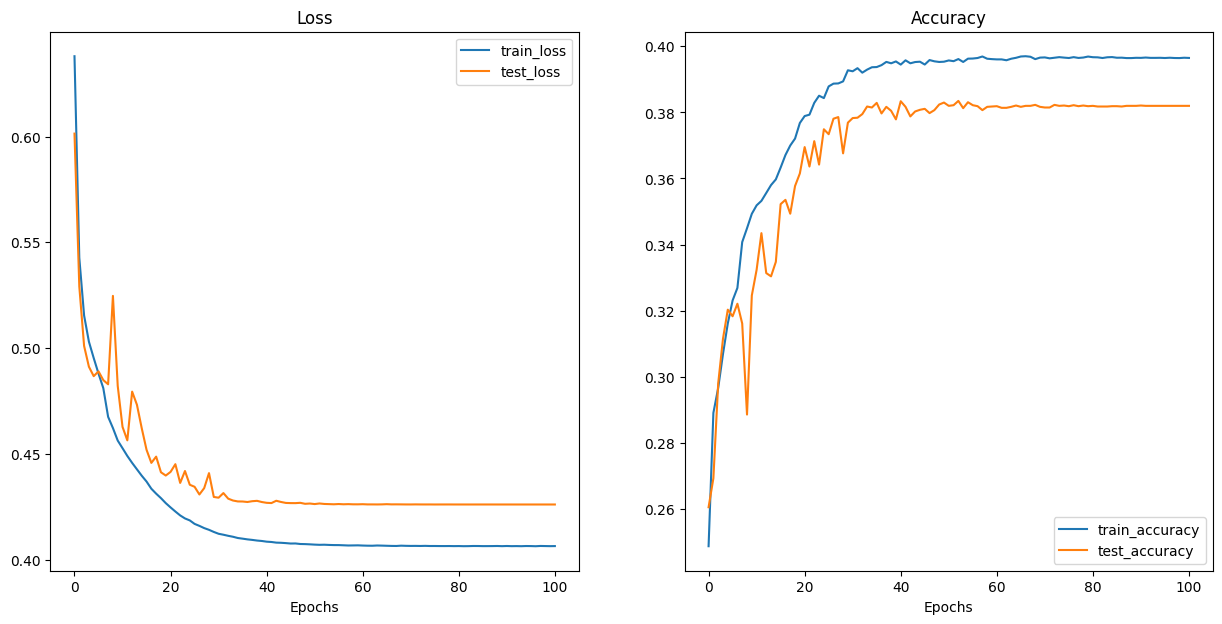

In [264]:
# Setup model with input parameters
MLP_clf = SimpleMLP(input_shape=3072, # one for every pixel (32x32x3 = 3072)
    hidden_units=16, # number of units in the hidden layer
    output_shape=len(class_names) # one for every class
).to(device)

# Setup optimizer
optimizer = torch.optim.SGD(params=MLP_clf.parameters(), lr=0.1)

# Setup accuracy function
mca = MulticlassAccuracy(num_classes=10, average='micro').to(device)

# Setup loss function
loss_fn = nn.MultiMarginLoss()

# Setup scheduler
scheduler = ExponentialLR(optimizer, gamma=0.9)

# Set number of epochs
epochs = 101

test_train_plot(model=MLP_clf,
               data_loader_train=train_dataloader,
               data_loader_test=test_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=mca,
               epochs=epochs,
               scheduler=scheduler)

The MLP performs worse than both the SVM (by **~18%**) and the NNs of last time; partly expected since this is not a very sophisticated MLP.

However, this was done without using PCA. We should examine whether we can somewhat close the gap by implementing it here too.

For this we will use `torch_pca` (https://torch-pca.readthedocs.io/en/latest/index.html), a package which emulates Scikit-Learn's PCA on PyTorch tensors.

In [254]:
# Set up the PyTorch PCA object
tPCA = torchPCA(0.98)

# We will need the whole dataset in order to apply PCA to it, so we will use the DataLoader with a batch size equal to the number of samples in the dataset to make a 'bulk' dataloader for this purpose

# Turn datasets into iterables (batches)
bulk_train_loader = DataLoader(tensor_train_data, # dataset to turn into iterable
    batch_size=50000, # number of samples per batch
    shuffle=False # option to shuffle data every epoch
)

bulk_test_loader = DataLoader(tensor_test_data,
    batch_size=10000,
    shuffle=False # don't necessarily have to shuffle the testing data
)

# Retrieve all training and testing data
pca_tensor_train_data, pca_tensor_train_labels = next(iter(bulk_train_loader))
pca_tensor_test_data, pca_tensor_test_labels = next(iter(bulk_test_loader))

# Flatten images (N, C, H, W) -> (N, C*H*W)
pca_tensor_train_data = pca_tensor_train_data.view(pca_tensor_train_data.size(0), -1)
pca_tensor_test_data = pca_tensor_test_data.view(pca_tensor_test_data.size(0), -1)

# Apply PCA
pca_tensor_train_data = tPCA.fit_transform(pca_tensor_train_data)
pca_tensor_test_data = tPCA.transform(pca_tensor_test_data)

# Verify PCA-transformed dimensions
print(pca_tensor_train_data.shape) 
print(pca_train_data.shape)

torch.Size([50000, 444])
(50000, 444)


Having applied PCA, we can clearly see the reduction in dimensionality, which is what causes the execution speedup.

To use this reduced data with our PyTorch model, we will create a new `class`, to which we will give our PCA-data to create a custom CIFAR-10 PCA dataset. Using a DataLoader on it, we can feed it to our model exactly as we did before.

In [255]:
# Create new class into which we will put the PCA-transformed data, to then be fed into a dataloader
class PCACIFAR10Dataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return self.data.size(0)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Create custom datasets for PCA-transformed data
pca_tensor_train_dataset = PCACIFAR10Dataset(pca_tensor_train_data, pca_tensor_train_labels)
pca_tensor_test_dataset = PCACIFAR10Dataset(pca_tensor_test_data, pca_tensor_test_labels)

# Create DataLoaders for batching
pca_train_loader = DataLoader(pca_tensor_train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

pca_test_loader = DataLoader(pca_tensor_test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False)



Finally, we can test the model with PCA-reduced data, taking care to use `input_shape=444` this time, as we noted the new dimension size above.

  1%|          | 1/101 [00:02<03:41,  2.22s/it]

Epoch: 0
---------
Train loss: 0.47141 | Train accuracy: 36.02%
Test loss: 0.39079 | Test accuracy: 40.95%



 21%|██        | 21/101 [00:47<03:05,  2.31s/it]

Epoch: 20
---------
Train loss: 0.31057 | Train accuracy: 48.20%
Test loss: 0.34831 | Test accuracy: 45.36%



 41%|████      | 41/101 [01:33<02:19,  2.32s/it]

Epoch: 40
---------
Train loss: 0.30322 | Train accuracy: 48.78%
Test loss: 0.34821 | Test accuracy: 45.28%



 60%|██████    | 61/101 [02:19<01:31,  2.28s/it]

Epoch: 60
---------
Train loss: 0.30229 | Train accuracy: 48.90%
Test loss: 0.34803 | Test accuracy: 45.49%



 80%|████████  | 81/101 [03:05<00:46,  2.33s/it]

Epoch: 80
---------
Train loss: 0.30214 | Train accuracy: 48.89%
Test loss: 0.34805 | Test accuracy: 45.44%



100%|██████████| 101/101 [03:51<00:00,  2.29s/it]

Epoch: 100
---------
Train loss: 0.30213 | Train accuracy: 48.90%
Test loss: 0.34806 | Test accuracy: 45.44%

Total training time: 231.418 seconds


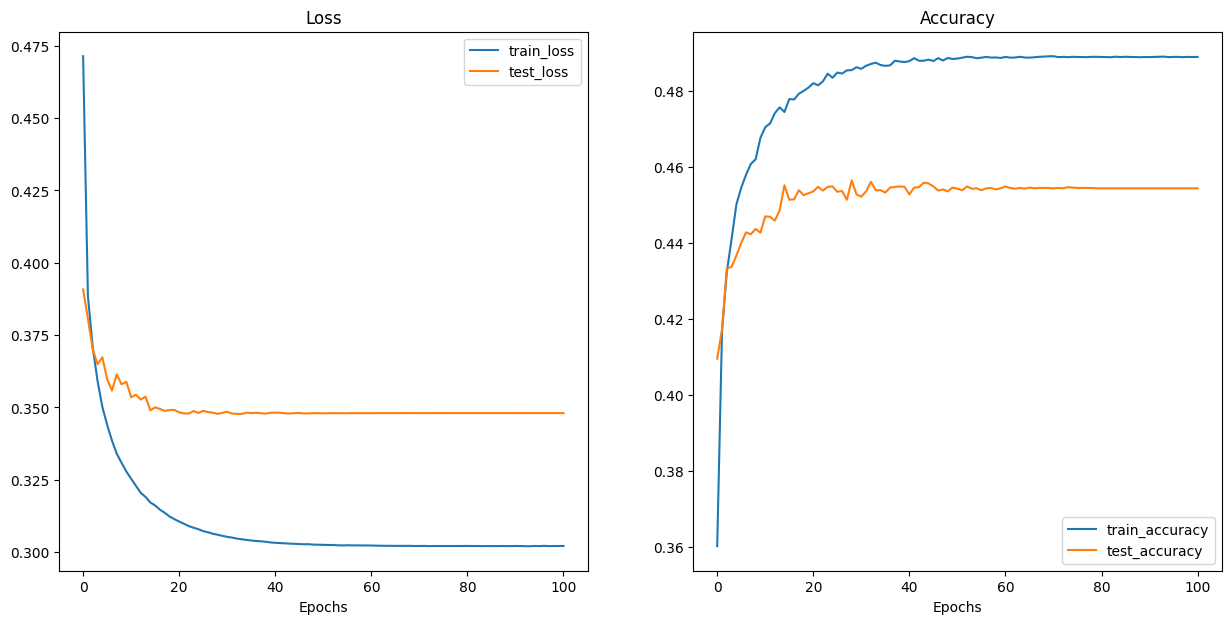

In [256]:
# Setup model with input parameters
MLP_clf = SimpleMLP(input_shape=444, # one for every 'pixel', ie feature
    hidden_units=16, # number of units in the hidden layer
    output_shape=len(class_names) # one for every class
).to(device)

# Setup optimizer
optimizer = torch.optim.SGD(params=MLP_clf.parameters(), lr=0.1)

# Setup accuracy function
mca = MulticlassAccuracy(num_classes=10, average='micro').to(device)

# Setup loss function
loss_fn = nn.MultiMarginLoss()

# Setup scheduler
scheduler = ExponentialLR(optimizer, gamma=0.9)

# Set number of epochs
epochs = 101

test_train_plot(model=MLP_clf,
               data_loader_train=pca_train_loader,
               data_loader_test=pca_test_loader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=mca,
               epochs=epochs,
               scheduler=scheduler)

The performance of our model has increased substantially. It takes **~10 minutes less** and gives a **~6%** larger testing accuracy. There is a notable increase in overfitting compared to before but since we gained in test accuracy, it is overall acceptable.

For the sake of completeness, we'll finish by using Scikit-Learn's implementations of the **1-NN**, **3-NN** and **Nearest Centroid** Classifiers, with and without PCA-reduced data, and seeing whether it makes a significant difference on them also. On top of that, we'll take our best performing MLP from the previous assignment and see how it does using PCA.

In [257]:
# Same process

k1nn = KNeighborsClassifier(n_neighbors=1)
k3nn = KNeighborsClassifier(n_neighbors=3)
ncc = NearestCentroid()

model_results = {}

for clf, name in zip([k1nn, k3nn, ncc], ['1-NN', '3-NN', 'Nearest Centroid']):

    clf_name = name

    start_time = timer()
    clf.fit(train_data_reshaped, train_labels.ravel())
    end_time = timer()
    
    model_results[clf_name] = {'Train accuracy': f"{clf.score(train_data_reshaped, train_labels.ravel())*100:.2f}%",
                               'Test accuracy': f"{clf.score(test_data_reshaped, test_labels.ravel())*100:.2f}%",
                               'Training time': f"{(end_time - start_time):.2f}s"}
    
original_classifier_results = pd.DataFrame(model_results)
original_classifier_results

,1-NN,3-NN,Nearest Centroid
Train accuracy,100.00%,57.90%,26.97%
Test accuracy,35.39%,33.03%,27.74%
Training time,0.00s,0.00s,0.51s


In [258]:
# Same yet again

k1nn = KNeighborsClassifier(n_neighbors=1)
k3nn = KNeighborsClassifier(n_neighbors=3)
ncc = NearestCentroid()

model_results = {}

for clf, name in zip([k1nn, k3nn, ncc], ['1-NN', '3-NN', 'Nearest Centroid']):

    clf_name = name

    start_time = timer()
    clf.fit(pca_train_data, train_labels.ravel())
    end_time = timer()
    
    model_results[clf_name] = {'Train accuracy': f"{clf.score(pca_train_data, train_labels.ravel())*100:.2f}%",
                               'Test accuracy': f"{clf.score(pca_test_data, test_labels.ravel())*100:.2f}%",
                               'Training time': f"{(end_time - start_time):.2f}s"}
    
pca_original_classifier_results = pd.DataFrame(model_results)
pca_original_classifier_results

,1-NN,3-NN,Nearest Centroid
Train accuracy,100.00%,58.69%,26.96%
Test accuracy,36.34%,33.81%,27.75%
Training time,0.03s,0.04s,0.17s


Not much has changed. **Nearest Centroid** performs pretty much exactly the same and **1-NN** and **3-NN** show barely any improvement - **~1%** and **~0.8%** respectively.

Now to the more sophisticated MLP, taken straight from the first assignment.

  1%|          | 1/101 [00:02<04:22,  2.62s/it]

Epoch: 0
---------
Train loss: 2.02107 | Train accuracy: 26.32%
Test loss: 1.78871 | Test accuracy: 36.33%



 21%|██        | 21/101 [00:52<03:19,  2.49s/it]

Epoch: 20
---------
Train loss: 1.37506 | Train accuracy: 50.66%
Test loss: 1.49468 | Test accuracy: 46.92%



 41%|████      | 41/101 [01:41<02:29,  2.48s/it]

Epoch: 40
---------
Train loss: 1.34442 | Train accuracy: 51.78%
Test loss: 1.49065 | Test accuracy: 47.15%



 60%|██████    | 61/101 [02:30<01:38,  2.47s/it]

Epoch: 60
---------
Train loss: 1.33959 | Train accuracy: 51.97%
Test loss: 1.49106 | Test accuracy: 47.26%



 80%|████████  | 81/101 [03:21<00:51,  2.59s/it]

Epoch: 80
---------
Train loss: 1.33905 | Train accuracy: 52.00%
Test loss: 1.49101 | Test accuracy: 47.28%



100%|██████████| 101/101 [04:12<00:00,  2.50s/it]

Epoch: 100
---------
Train loss: 1.33887 | Train accuracy: 52.00%
Test loss: 1.49103 | Test accuracy: 47.28%

Total training time: 252.500 seconds


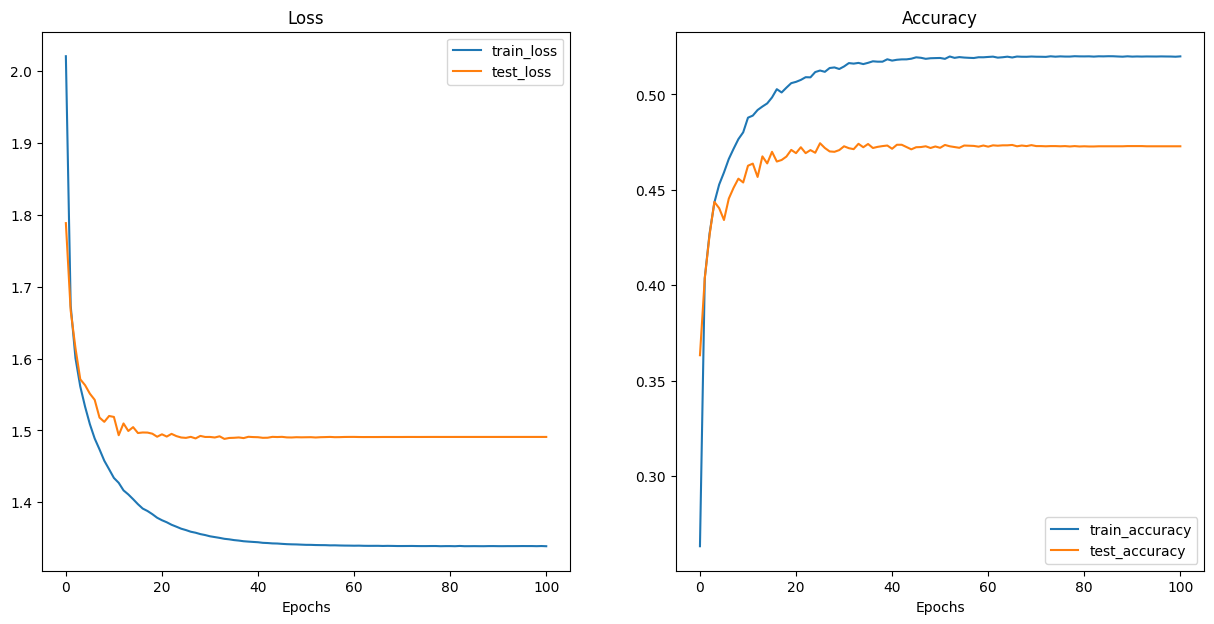

In [261]:
class BasicMLP(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # neural networks like their inputs in vector form
            nn.Linear(in_features=input_shape, out_features=hidden_units), # in_features = number of features in a data sample (3072 pixels)
            nn.ReLU(),
            nn.Dropout(p=0.25),
            nn.Linear(in_features=hidden_units, out_features=hidden_units), 
            nn.ReLU(),
            nn.Dropout(p=0.25),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.layer_stack(x)

# Setup model with input parameters
MLP_model = BasicMLP(input_shape=444, # one for every feature
    hidden_units=16, # number of units in the hidden layer
    output_shape=len(class_names) # one for every class
).to(device)

# Setup optimizer
optimizer = torch.optim.SGD(params=MLP_model.parameters(), lr=0.1)

# Setup accuracy function
mca = MulticlassAccuracy(num_classes=10, average='micro').to(device)

# Setup loss function
loss_fn = nn.CrossEntropyLoss()

# Setup scheduler
scheduler = ExponentialLR(optimizer, gamma=0.9)

# Set number of epohcs
epochs = 101

test_train_plot(model=MLP_model,
               data_loader_train=pca_train_loader,
               data_loader_test=pca_test_loader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=mca,
               epochs=epochs,
               scheduler=scheduler)

Compared to the simpler MLP, performance has increased by **~2%** at the cost of **~20** seconds.

### **Conclusion**

The SVM approach provides very respectable results. Although the CNN from last time still beats it in terms of accuracy, the SVM takes less time to train and it still manages to reach the #2 spot in test accuracy.

Specifically, the performance numbers are as follows:

-   CNN --- **66.54%** accuracy after **394.153** seconds
-   SVM --- **56.71%** accuracy after **206.95** seconds

- ComplexMLP --- **47.28%** accuracy after **252.500** seconds
- SimpleMLP --- **45.44%** accuracy after **231.418** seconds

- 1-NN --- **36.34%**
- 3-NN --- **33.81%**
- NC ---**27.75%**


**Resources and tools used:**

**ROCm**

https://gist.githubusercontent.com/damico/484f7b0a148a0c5f707054cf9c0a0533/raw/43c317bfbde626d9112d44462d815613194988e0/test-rocm.py

https://rocm.docs.amd.com/projects/install-on-linux/en/develop/install/3rd-party/pytorch-install.html

https://rocm.docs.amd.com/projects/install-on-linux/en/latest/install/native-install/ubuntu.html


**PyTorch**

https://pytorch.org/

https://www.dataquest.io/blog/pytorch-for-beginners/

**PCA for PyTorch**

https://github.com/valentingol/torch_pca

https://torch-pca.readthedocs.io/en/latest/

**Useful 'PrintLayer' for debugging PyTorch models**

https://discuss.pytorch.org/t/how-do-i-print-output-of-each-layer-in-sequential/5773/3


**Scikit-Learn**

https://scikit-learn.org/stable/index.html


**Keras**

https://keras.io/

https://keras.io/api/datasets/cifar10/


**The CIFAR-10 image database**

https://www.cs.toronto.edu/~kriz/cifar.html

Learning Multiple Layers of Features from Tiny Images, Alex Krizhevsky, 2009.
(https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf)


**SVM, OvO & OvR explainer**

https://www.geeksforgeeks.org/support-vector-machine-algorithm/

https://machinelearningmastery.com/one-vs-rest-and-one-vs-one-for-multi-class-classification/


**VSCode**

https://code.visualstudio.com/

GitHub Copilot was utilized for error correction/debugging and autocomplete.